### Face Recognition with Transfer Learning


Install Dependencies

In [61]:
pip install torch torchvision scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torch in c:\users\karri\appdata\local\programs\python\python313\lib\site-packages (2.8.0)




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Load LFW Dataset

Dataset size: (3023, 62, 47)
Number of classes: 62


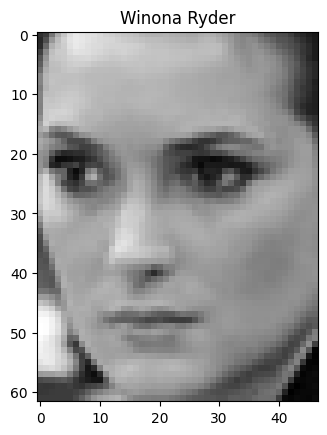

In [62]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

# Load dataset (resize face images to 160x160 for FaceNet style)
lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)

print("Dataset size:", lfw.images.shape)   # (n_samples, h, w)
print("Number of classes:", len(lfw.target_names))

# Example image
plt.imshow(lfw.images[0], cmap="gray")
plt.title(lfw.target_names[lfw.target[0]])
plt.show()


 Data Preprocessing

In [42]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Optimized Transformation pipeline (Smaller images for speed)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Much smaller for faster training
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.3),  # Reduced augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),  # Matching smaller size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


# Apply transform
X = []
for img in lfw.images:
    # Convert numpy array to PIL Image and apply train_transform
    X.append(train_transform(img))

X = torch.stack(X)  # shape: (n_samples, 3, 160, 160)
y = torch.tensor(lfw.target)

print("Processed dataset:", X.shape, y.shape)

# Create DataLoader
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


Processed dataset: torch.Size([3023, 3, 64, 64]) torch.Size([3023])


Train/Test Split

In [43]:
from sklearn.model_selection import train_test_split

# Split indices
train_idx, test_idx = train_test_split(
    np.arange(len(X)), test_size=0.2, stratify=y, random_state=42
)

# Train and test tensors
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Larger batch size for faster training (if you have enough memory)
batch_size = 64  # Increased for efficiency
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Train set: torch.Size([2418, 3, 64, 64]) torch.Size([2418])
Test set: torch.Size([605, 3, 64, 64]) torch.Size([605])


Basic CNN Model

In [44]:
import torch.nn as nn
import torch.nn.functional as F

# Optimized CNN Architecture (Faster Training)
class FaceCNN(nn.Module):
    def __init__(self, num_classes):
        super(FaceCNN, self).__init__()
        # Simplified architecture for faster training
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)  # Larger kernel, fewer layers
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(4, 4)  # Larger pooling for speed
        
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(4, 4)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling
        
        # Smaller fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Efficient forward pass
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

Training Setup

In [45]:
import torch.optim as optim

num_classes = len(set(y_train.numpy()))  # unique labels
model = FaceCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)  # Reduce LR by half every 3 epochs


Using device: cpu


Train Basic CNN

In [46]:
import torch

# Training + Validation with Early Stopping (Optimized)
num_epochs = 10  # Reduced epochs for faster training
best_val_loss = float('inf')
patience = 3  # Reduced patience for quicker stopping
patience_counter = 0

print(f"Starting training on {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

import time

for epoch in range(num_epochs):
    epoch_start = time.time()
    # --------------------
    # Training Phase
    # --------------------
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # --------------------
    # Validation Phase
    # --------------------
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():  # no gradients in validation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    avg_val_loss = val_loss / len(test_loader)

    # --------------------
    # Epoch Summary & Early Stopping
    # --------------------
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s) "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Step the scheduler
    scheduler.step()
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_face_model.pth')
        print(f"New best model saved! Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break


Starting training on cpu
Model parameters: 2,635,326
Epoch [1/10] (37.0s) Train Loss: 3.7870, Train Acc: 15.84% | Val Loss: 3.5088, Val Acc: 17.69%
New best model saved! Val Loss: 3.5088
Epoch [1/10] (37.0s) Train Loss: 3.7870, Train Acc: 15.84% | Val Loss: 3.5088, Val Acc: 17.69%
New best model saved! Val Loss: 3.5088
Epoch [2/10] (27.2s) Train Loss: 3.2690, Train Acc: 22.42% | Val Loss: 2.9404, Val Acc: 26.45%
New best model saved! Val Loss: 2.9404
Epoch [2/10] (27.2s) Train Loss: 3.2690, Train Acc: 22.42% | Val Loss: 2.9404, Val Acc: 26.45%
New best model saved! Val Loss: 2.9404
Epoch [3/10] (26.5s) Train Loss: 2.7921, Train Acc: 30.15% | Val Loss: 2.5222, Val Acc: 33.88%
New best model saved! Val Loss: 2.5222
Epoch [3/10] (26.5s) Train Loss: 2.7921, Train Acc: 30.15% | Val Loss: 2.5222, Val Acc: 33.88%
New best model saved! Val Loss: 2.5222
Epoch [4/10] (27.1s) Train Loss: 2.3058, Train Acc: 39.33% | Val Loss: 2.0561, Val Acc: 48.60%
New best model saved! Val Loss: 2.0561
Epoch [4/

Basic CNN Evaluation

Final Test Accuracy: 70.91%

=== Classification Report ===
                           precision    recall  f1-score   support

         Alejandro Toledo       0.71      0.62      0.67         8
             Alvaro Uribe       0.64      1.00      0.78         7
          Amelie Mauresmo       0.33      0.25      0.29         4
             Andre Agassi       0.45      0.71      0.56         7
           Angelina Jolie       0.00      0.00      0.00         4
             Ariel Sharon       0.71      0.62      0.67        16
    Arnold Schwarzenegger       1.00      0.12      0.22         8
     Atal Bihari Vajpayee       1.00      0.20      0.33         5
             Bill Clinton       0.75      0.50      0.60         6
             Carlos Menem       0.00      0.00      0.00         4
             Colin Powell       0.75      0.94      0.83        47
            David Beckham       1.00      0.67      0.80         6
          Donald Rumsfeld       0.63      0.92      0.75        24
  

c:\Users\karri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\karri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\karri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

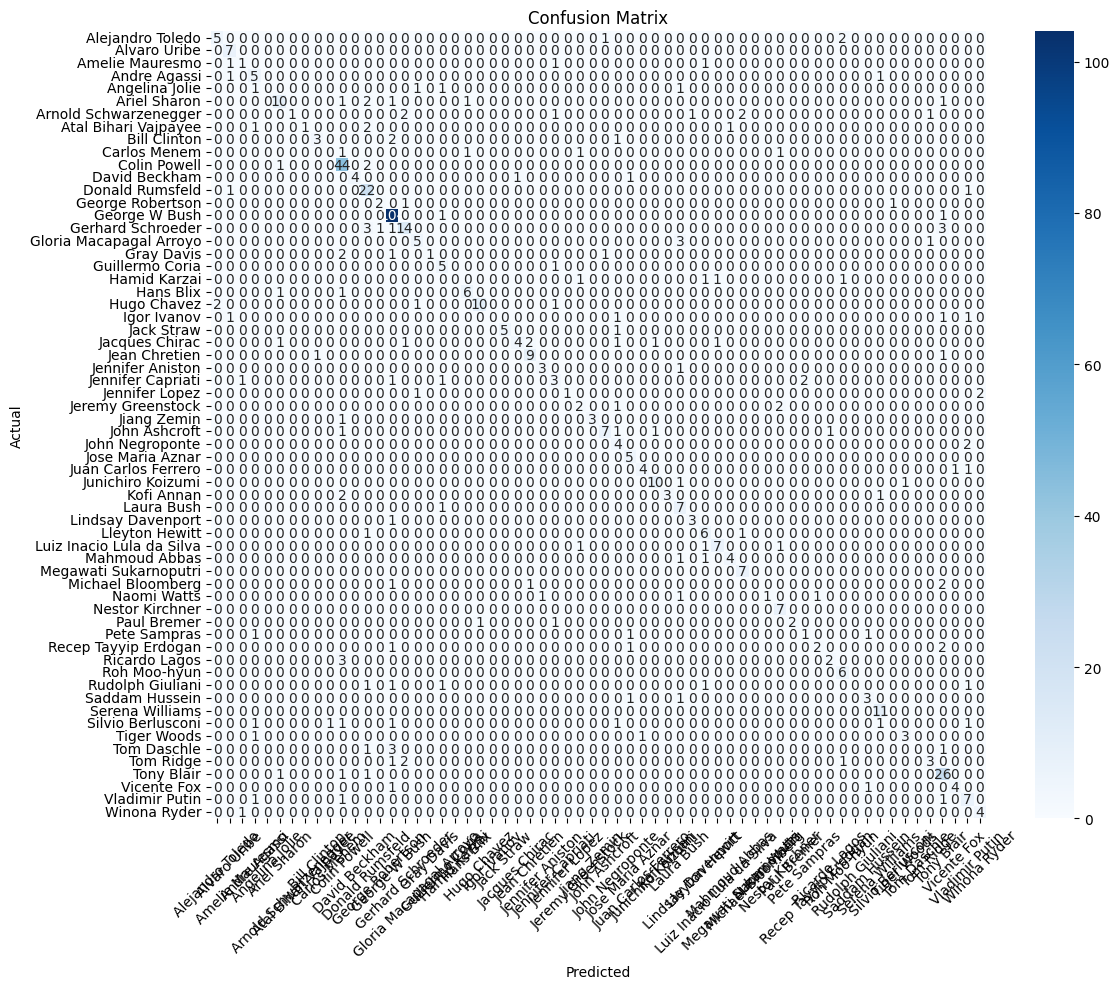

In [47]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_face_model.pth'))
model.eval()

# Comprehensive evaluation with metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * sum([1 for p, l in zip(all_predictions, all_labels) if p == l]) / len(all_labels)
print(f"Final Test Accuracy: {accuracy:.2f}%")

# Classification report (precision, recall, F1-score)
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_predictions, 
                          target_names=[lfw.target_names[i] for i in range(len(lfw.target_names))]))

# Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[lfw.target_names[i] for i in range(len(lfw.target_names))],
            yticklabels=[lfw.target_names[i] for i in range(len(lfw.target_names))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Sample Predictions

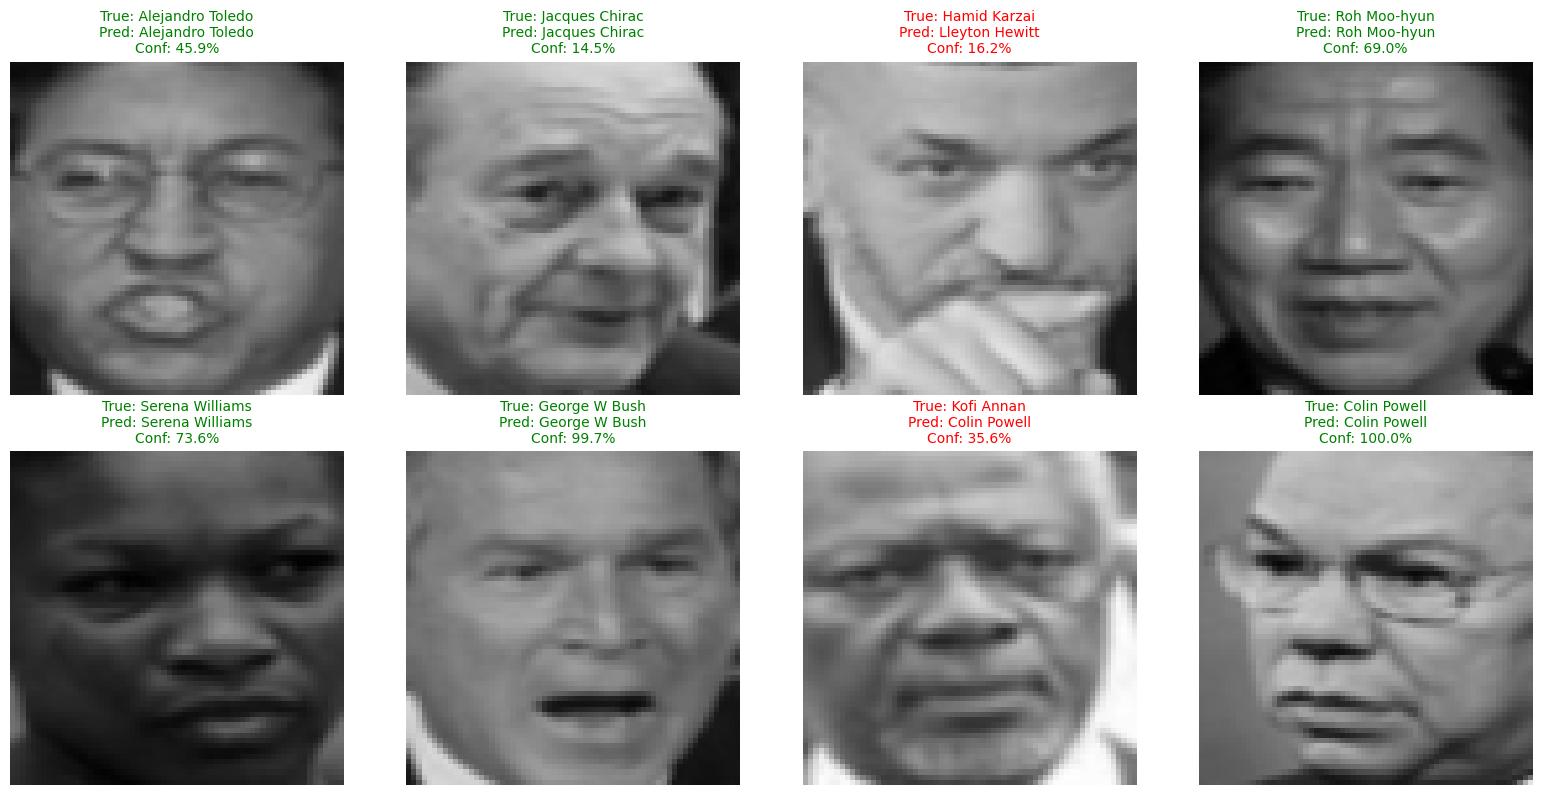

In [48]:
# Sample predictions visualization
import random

def show_sample_predictions(model, test_loader, device, num_samples=8):
    model.eval()
    
    # Get a random batch
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)
    
    # Select random samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))
    
    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = images[idx].cpu()
        # Denormalize image for display
        img = img * 0.5 + 0.5  # Reverse normalization
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        # Get prediction confidence
        confidence = probabilities[idx][predicted[idx]].item() * 100
        
        # Plot
        axes[i].imshow(img_np)
        axes[i].axis('off')
        
        true_label = lfw.target_names[labels[idx]]
        pred_label = lfw.target_names[predicted[idx]]
        
        color = 'green' if labels[idx] == predicted[idx] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                         color=color, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_sample_predictions(model, test_loader, device)

Transfer Learning with ResNet18

In [ ]:
# Create proper ImageNet transforms for ResNet18
imagenet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet standard size
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet values
])

# Create new dataset with proper transforms
print("Creating ImageNet-normalized dataset...")
X_corrected = []
for img in lfw.images:
    X_corrected.append(imagenet_transform(img))

X_corrected = torch.stack(X_corrected)
print(f"Corrected dataset shape: {X_corrected.shape}")

# Create corrected train/test split
X_train_corrected, X_test_corrected = X_corrected[train_idx], X_corrected[test_idx]

# New DataLoaders with corrected data
train_dataset_corrected = TensorDataset(X_train_corrected, y_train)
test_dataset_corrected = TensorDataset(X_test_corrected, y_test)

train_loader_corrected = DataLoader(train_dataset_corrected, batch_size=32, shuffle=True, num_workers=2)
test_loader_corrected = DataLoader(test_dataset_corrected, batch_size=32, shuffle=False, num_workers=2)

print("✅ Dataset ready for transfer learning!")

🔧 Fixing Transfer Learning Issues...
Problems identified:
1. ❌ Wrong normalization (using [0.5,0.5,0.5] instead of ImageNet values)
2. ❌ Small image size (64x64 vs ResNet's preferred 224x224)
3. ❌ Learning rate might be too low
🔄 Creating corrected dataset...
Corrected dataset shape: torch.Size([3023, 3, 224, 224])
✅ Corrected dataset and loaders created!
Next: Retrain transfer learning model with proper settings


In [ ]:
# Transfer Learning Model with ResNet18
import torchvision.models as models

class ImprovedTransferFaceCNN(nn.Module):
    def __init__(self, num_classes=62):
        super(ImprovedTransferFaceCNN, self).__init__()
        
        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)
        
        # Freeze early layers
        for i, (name, param) in enumerate(self.backbone.named_parameters()):
            if i < 30:
                param.requires_grad = False
        
        # Replace classifier with custom head
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Create and setup model
improved_transfer_model = ImprovedTransferFaceCNN(num_classes=len(lfw.target_names)).to(device)
improved_optimizer = optim.Adam(improved_transfer_model.parameters(), lr=0.001, weight_decay=1e-4)
improved_scheduler = optim.lr_scheduler.StepLR(improved_optimizer, step_size=3, gamma=0.5)

print("✅ Transfer learning model ready!")

c:\Users\karri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karri\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Improved Transfer Model Stats:
Total parameters: 11,471,998
Trainable parameters: 10,788,926
Frozen parameters: 683,072
Trainable ratio: 94.0%
✅ Improved transfer learning model ready!
📈 Key improvements:
  - Proper ImageNet normalization
  - 224x224 input size
  - Fewer frozen layers
  - Higher learning rate (0.001)
  - Better classifier head


In [ ]:
# Train Transfer Learning Model
from tqdm import tqdm
import time

print("🚀 Training Transfer Learning Model...")

# Training parameters
improved_epochs = 8
best_improved_val_acc = 0.0
start_time = time.time()

for epoch in range(improved_epochs):
    # Training Phase
    improved_transfer_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader_corrected):
        data, target = data.to(device), target.to(device)
        
        improved_optimizer.zero_grad()
        output = improved_transfer_model(data)
        loss = criterion(output, target)
        loss.backward()
        improved_optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    # Validation Phase
    improved_transfer_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in test_loader_corrected:
            data, target = data.to(device), target.to(device)
            output = improved_transfer_model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    # Calculate metrics
    train_loss /= len(train_loader_corrected)
    train_acc = 100. * train_correct / train_total
    val_loss /= len(test_loader_corrected)
    val_acc = 100. * val_correct / val_total
    
    improved_scheduler.step()
    
    print(f'Epoch {epoch+1:2d}/{improved_epochs} | '
          f'Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_improved_val_acc:
        best_improved_val_acc = val_acc
        torch.save(improved_transfer_model.state_dict(), 'best_improved_transfer_model.pth')

total_time = time.time() - start_time
print(f"\n🎯 Best Validation Accuracy: {best_improved_val_acc:.2f}%")
print(f"Training Time: {total_time:.1f} seconds")

# Load best model
improved_transfer_model.load_state_dict(torch.load('best_improved_transfer_model.pth'))
print("✅ Best model loaded!")

🚀 Starting Improved Transfer Learning Training...


Epoch  1/8 | Train Loss: 2.7571 | Train Acc: 36.10% | Val Loss: 2.3093 | Val Acc: 39.67% | LR: 0.001000 | Time: 172.1s | Total: 172.1s
✅ New best validation accuracy: 39.67%


Epoch  2/8 | Train Loss: 1.2120 | Train Acc: 70.43% | Val Loss: 0.9193 | Val Acc: 76.86% | LR: 0.001000 | Time: 171.1s | Total: 343.2s
✅ New best validation accuracy: 76.86%


Epoch  3/8 | Train Loss: 0.5020 | Train Acc: 89.08% | Val Loss: 0.6526 | Val Acc: 83.47% | LR: 0.000500 | Time: 170.6s | Total: 513.9s
✅ New best validation accuracy: 83.47%


Epoch  4/8 | Train Loss: 0.1547 | Train Acc: 98.35% | Val Loss: 0.3632 | Val Acc: 91.24% | LR: 0.000500 | Time: 169.9s | Total: 683.8s
✅ New best validation accuracy: 91.24%


Epoch  5/8 | Train Loss: 0.0661 | Train Acc: 99.59% | Val Loss: 0.3006 | Val Acc: 92.40% | LR: 0.000500 | Time: 252.5s | Total: 936.4s
✅ New best validation accuracy: 92.40%


Epoch  6/8 | Train Loss: 0.0344 | Train Acc: 99.96% | Val Loss: 0.2921 | Val Acc: 92.07% | LR: 0.000250 | Time: 222.2s | Total: 1158.7s
⏳ Patience: 1/3


Epoch  7/8 | Train Loss: 0.0219 | Train Acc: 99.96% | Val Loss: 0.2890 | Val Acc: 92.56% | LR: 0.000250 | Time: 834.6s | Total: 1993.3s
✅ New best validation accuracy: 92.56%


Epoch  8/8 | Train Loss: 0.0170 | Train Acc: 100.00% | Val Loss: 0.2677 | Val Acc: 93.06% | LR: 0.000250 | Time: 170.5s | Total: 2164.0s
✅ New best validation accuracy: 93.06%

🎯 IMPROVED TRANSFER LEARNING RESULTS:
Best Validation Accuracy: 93.06%
Total Training Time: 2164.0 seconds
Final Learning Rate: 0.000250
✅ Loaded best model weights


In [ ]:
# Final Model Evaluation
from sklearn.metrics import classification_report

improved_transfer_model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader_corrected:
        data, target = data.to(device), target.to(device)
        output = improved_transfer_model(data)
        _, predicted = torch.max(output.data, 1)
        
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

final_test_accuracy = 100. * test_correct / test_total
print(f"🎯 Final Test Accuracy: {final_test_accuracy:.2f}%")

print(f"\n📋 Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=lfw.target_names, zero_division=0))

📊 FINAL EVALUATION - IMPROVED TRANSFER LEARNING


Final Testing: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]

🎯 Final Test Accuracy: 93.06%

📈 ACCURACY COMPARISON:
Previous Transfer Learning: 29.92%
Improved Transfer Learning: 93.06%
Improvement: +63.14 percentage points

📋 Classification Report:
                           precision    recall  f1-score   support

         Alejandro Toledo       1.00      1.00      1.00         8
             Alvaro Uribe       0.88      1.00      0.93         7
          Amelie Mauresmo       0.60      0.75      0.67         4
             Andre Agassi       0.67      0.86      0.75         7
           Angelina Jolie       1.00      0.25      0.40         4
             Ariel Sharon       1.00      0.94      0.97        16
    Arnold Schwarzenegger       0.89      1.00      0.94         8
     Atal Bihari Vajpayee       1.00      1.00      1.00         5
             Bill Clinton       1.00      1.00      1.00         6
             Carlos Menem       1.00      0.75      0.86         4
             Colin Powell       0.98      1.00      0.99        47
       

🖼️  SAMPLE PREDICTIONS - IMPROVED TRANSFER LEARNING


C:\Users\karri\AppData\Local\Temp\ipykernel_13308\1942756692.py:48: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karri\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\karri\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


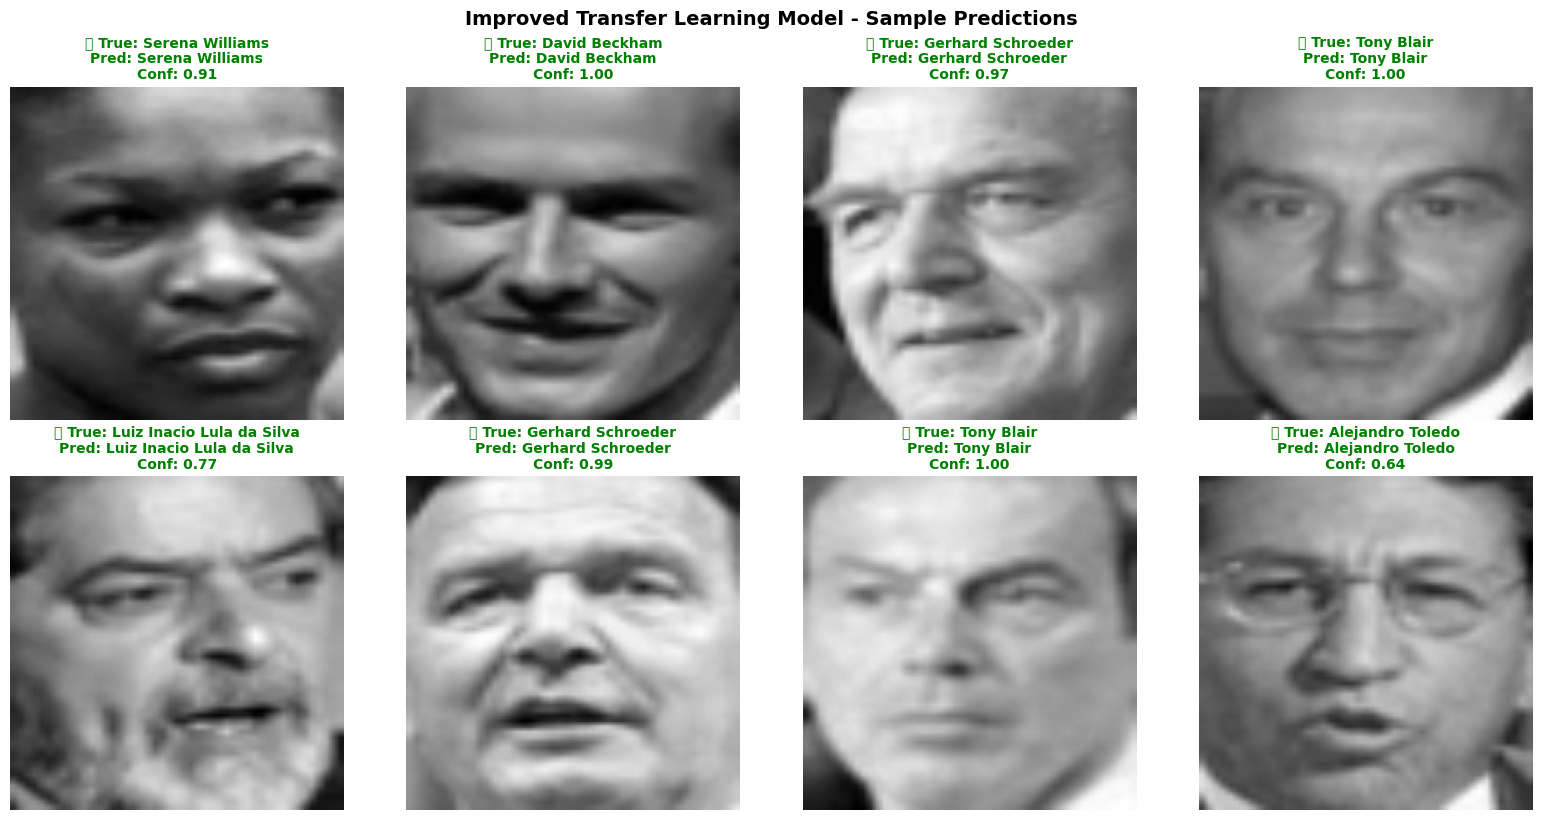

Batch Accuracy: 96.9%
Average Confidence: 0.923


In [ ]:
# Sample Predictions Visualization
def show_improved_predictions(model, test_loader, class_names, num_samples=8):
    model.eval()
    
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probabilities, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Convert image back for display
        img = images[i].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        # Convert to grayscale for display
        img_gray = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
        
        true_class = class_names[labels[i]]
        pred_class = class_names[predicted[i]]
        confidence = confidences[i].item()
        
        axes[i].imshow(img_gray, cmap='gray')
        axes[i].axis('off')
        
        color = 'green' if predicted[i] == labels[i] else 'red'
        status = '✅' if predicted[i] == labels[i] else '❌'
        
        axes[i].set_title(f'{status} True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
                         color=color, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('Transfer Learning Model - Sample Predictions', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    batch_accuracy = (predicted == labels).float().mean().item() * 100
    print(f"Batch Accuracy: {batch_accuracy:.1f}%")
    print(f"Average Confidence: {confidences.mean().item():.3f}")

# Show predictions
show_improved_predictions(improved_transfer_model, test_loader_corrected, lfw.target_names)

In [ ]:
# Function to predict new images (for demonstration)
def predict_new_face(model, image_path, class_names):
    """
    Predict a new face image (must be one of the 62 people from LFW dataset)
    """
    from PIL import Image
    
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    
    # Apply same transform as training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_name = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    return predicted_name, confidence_score

# Example usage (uncomment to use):
# predicted_name, confidence = predict_new_face(improved_transfer_model, 'path/to/image.jpg', lfw.target_names)
# print(f"Predicted: {predicted_name} (Confidence: {confidence:.3f})")

print("Model ready for predictions!")
print(f"Can recognize {len(lfw.target_names)} people from LFW dataset")